In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec


In [2]:
# load and clean zip code dataset (zip, gnn, and latitude longitude )
working_directory = os.getcwd()
df = pd.read_excel(working_directory + '/Residential Facilities.xlsx')

print('Dropping ' + str(df.isnull().values.any(axis=1).sum()) + ' zip codes out of ' + str(df.shape[0]) + ' because of nan values')
df.dropna(axis = 0, inplace=True)

df['LOG_COUNT'] = np.log10(df['COUNT'])
df['COUNT'].describe()

Dropping 2 zip codes out of 648 because of nan values


count      646.000000
mean      8950.208978
std       6524.243193
min          1.000000
25%       3227.500000
50%       8821.500000
75%      13304.000000
max      27534.000000
Name: COUNT, dtype: float64

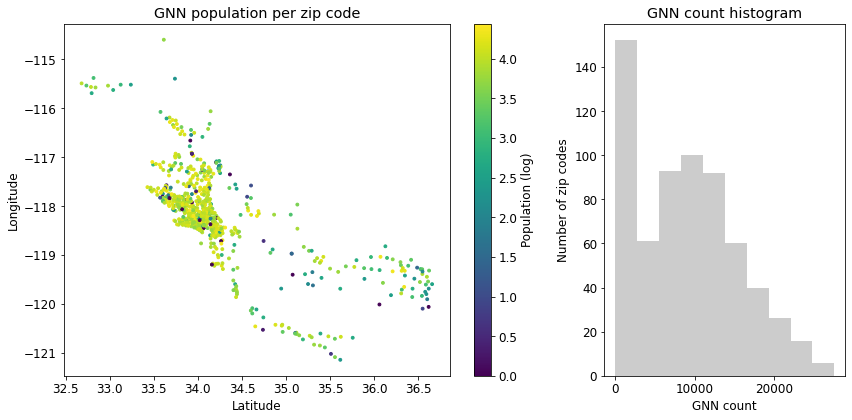

In [3]:
# EDA of dataset
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 12})

gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
plt.subplot(gs[0])
plt.scatter(df['Median Latitude'],df['Median Longitude'], c = df['LOG_COUNT'], s=8)
cb = plt.colorbar()
cb.ax.set_ylabel('Population (log)')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('GNN population per zip code')

plt.subplot(gs[1])
plt.hist(df['COUNT'], color= [.8, .8, .8])
plt.xlabel('GNN count')
plt.ylabel('Number of zip codes')
plt.title('GNN count histogram')

plt.tight_layout()
plt.show()


# Build distance matrix rquest using Google Maps API 

In [ ]:
myfile = open(r'C:\Users\jacheung\Dropbox\API Keys\maps_API.txt')
API_key = myfile.read()

# build zip list for google api request 
# note that commas are replaced with %2C
df['API lat long'] = df['Median Latitude'].astype(str) + '%2C' + df['Median Longitude'].astype(str)
zip_list = "|".join(df['API lat long'][:10].to_list()) # test with first 10 elements first
# zip_list = "|".join(df['API lat long'].to_list())

# build request components 
foundation = 'https://maps.googleapis.com/maps/api/distancematrix/json?'
units = 'units=imperial'
origin = 'origins=' + zip_list
destination = 'destinations=' + zip_list
API = 'key=' + API_key

# build request
request = foundation + units + '&' + origin + '&' + destination + '&' + API

request

# Run request through Google Maps API 

In [ ]:
import urllib.request
import json

res = urllib.request.urlopen(request).read()
data = json.loads(res.decode())
print(data)

In [ ]:
# loop through zip and add zip codes till target size for cluster

cluster_num = 30
cluster_target = df['COUNT'].sum()/cluster_num